In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('test.csv')

df.head()

,id,article,highlights
0,92c514c913c0bdfe25341af9fd72b29db544099b,Ever noticed how plane seats appear to be gett...,Experts question if packed out planes are put...
1,2003841c7dc0e7c5b1a248f9cd536d727f27a45a,A drunk teenage boy had to be rescued by secur...,Drunk teenage boy climbed into lion enclosure ...
2,91b7d2311527f5c2b63a65ca98d21d9c92485149,Dougie Freedman is on the verge of agreeing a ...,Nottingham Forest are close to extending Dougi...
3,caabf9cbdf96eb1410295a673e953d304391bfbb,Liverpool target Neto is also wanted by PSG an...,Fiorentina goalkeeper Neto has been linked wit...
4,3da746a7d9afcaa659088c8366ef6347fe6b53ea,Bruce Jenner will break his silence in a two-h...,"Tell-all interview with the reality TV star, 6..."


In [3]:
# Function to count words in a text column
def count_words(text):
    words = text.split()
    return len(words)

# Apply the function to the DataFrame column
df['WordCount'] = df['article'].apply(count_words)
df.head()

,id,article,highlights,WordCount
0,92c514c913c0bdfe25341af9fd72b29db544099b,Ever noticed how plane seats appear to be gett...,Experts question if packed out planes are put...,370
1,2003841c7dc0e7c5b1a248f9cd536d727f27a45a,A drunk teenage boy had to be rescued by secur...,Drunk teenage boy climbed into lion enclosure ...,311
2,91b7d2311527f5c2b63a65ca98d21d9c92485149,Dougie Freedman is on the verge of agreeing a ...,Nottingham Forest are close to extending Dougi...,110
3,caabf9cbdf96eb1410295a673e953d304391bfbb,Liverpool target Neto is also wanted by PSG an...,Fiorentina goalkeeper Neto has been linked wit...,308
4,3da746a7d9afcaa659088c8366ef6347fe6b53ea,Bruce Jenner will break his silence in a two-h...,"Tell-all interview with the reality TV star, 6...",749


<AxesSubplot:>

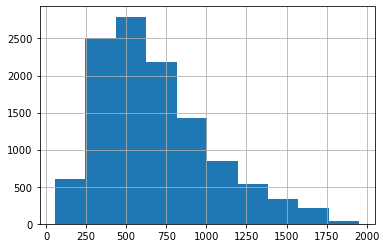

In [4]:
df['WordCount'].hist()

In [5]:
len(df)

11490

In [6]:
df.isnull().sum()

id            0
article       0
highlights    0
WordCount     0
dtype: int64

In [7]:
df['WordCount'].describe()

count    11490.000000
mean       683.511575
std        348.402755
min         55.000000
25%        419.000000
50%        613.000000
75%        876.000000
max       1954.000000
Name: WordCount, dtype: float64

In [8]:
import pandas as pd
import numpy as np
import random

import os

# machine learning modeling
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

# nlp word processing
import re
from nltk import pos_tag
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer 

#plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Pipelines
from imblearn.pipeline import Pipeline, make_pipeline

# SMOTE
from imblearn.over_sampling import SMOTE

plt.style.use('ggplot')

In [9]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

sw = stopwords.words('english')

punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~“!#'

no_accents_re = re.compile('^[a-z]+$')
'''This line compiles a regular expression pattern that matches 
words consisting only of lowercase letters without any accents.'''

accents = ['á', 'â', 'ã', 'à', 'å', 'ª', 'ç', 'è', '¼', '¾', 'î', 'ï', 'ì', 'ó', 'ö', 'ð', 'ü', 'ù', 'û', 'ý']
'''This list contains various accent characters that need to be removed from the words.'''

at_symbols = re.compile('[@][a-zA-Z]*')
'''Compile a regular expression pattern that matches strings consisting only of digits.'''

num_re = re.compile('^\d+$')
'''The text string (txt) is split into a list of words based on whitespace.'''


    
    
def remove_punctuation(text, punctuation):
    for char in punctuation:
        text = text.replace(char, '')
    return text

def remove_at_symbols(text, twitter_re):
    words = text.split()
    filtered_words = []
    for word in words:
        if not twitter_re.match(word):
            filtered_words.append(word)
    return ' '.join(filtered_words)

def remove_numbers(text, num_re):
    words = text.split()
    filtered_words = []
    for word in words:
        if not num_re.match(word):
            filtered_words.append(word)
    return ' '.join(filtered_words)

def remove_accents(text, accents, no_accents_re):
    words = text.split()
    filtered_words = []
    for word in words:
        if no_accents_re.match(word):
            filtered_words.append(word)
    return ' '.join(filtered_words)

def txt_clean(txt, stop_words=sw):
    t = txt.lower()
    t = remove_punctuation(t, punctuation)
    t = remove_at_symbols(t, twitter_re)
    t = remove_numbers(t, num_re)
    t = remove_accents(t, accents, no_accents_re)
    t = t.split()
    t = [w for w in t if w not in stop_words and w]
    t = pos_tag(t)
    t = [(w[0], get_wordnet_pos(w[1])) for w in t]
    lem = WordNetLemmatizer()
    t = [lem.lemmatize(w[0], w[1]) for w in t]
    return ' '.join(t)

df['article_clean'] = df['article'].map(txt_clean)

df.head()

,id,article,highlights,WordCount,article_clean
0,92c514c913c0bdfe25341af9fd72b29db544099b,Ever noticed how plane seats appear to be gett...,Experts question if packed out planes are put...,370,ever notice plane seat appear get small small ...
1,2003841c7dc0e7c5b1a248f9cd536d727f27a45a,A drunk teenage boy had to be rescued by secur...,Drunk teenage boy climbed into lion enclosure ...,311,drunk teenage boy rescue security jump lion en...
2,91b7d2311527f5c2b63a65ca98d21d9c92485149,Dougie Freedman is on the verge of agreeing a ...,Nottingham Forest are close to extending Dougi...,110,dougie freedman verge agree new twoyear deal r...
3,caabf9cbdf96eb1410295a673e953d304391bfbb,Liverpool target Neto is also wanted by PSG an...,Fiorentina goalkeeper Neto has been linked wit...,308,liverpool target neto also want psg club spain...
4,3da746a7d9afcaa659088c8366ef6347fe6b53ea,Bruce Jenner will break his silence in a two-h...,"Tell-all interview with the reality TV star, 6...",749,bruce jenner break silence twohour interview d...


In [10]:
df['article'][10]

"Biting his nails nervously, these are the first pictures of the migrant boat captain accused of killing 900 men, women and children in one of the worst maritime disasters since World War Two. Tunisian skipper Mohammed Ali Malek, 27, was arrested when he stepped onto Sicilian soil last night, some 24 hours after his  boat capsized in the Mediterranean. Before leaving the Italian coastguard vessel, however, he was forced to watch the bodies of 24 victims of the tragedy being carried off the ship for burial on the island of Malta. He was later charged with multiple manslaughter, causing a shipwreck and aiding illegal immigration. Prosecutors claim he contributed to the disaster by mistakenly ramming the overcrowded fishing boat into a merchant ship that had come to its rescue. As a result of the collision, the migrants shifted position on the boat, which was already off balance, causing it to overturn. Scroll down for videos . Nervous:\xa0Tunisian boat captain Mohammed Ali Malek (centre)

In [11]:
df['article_clean'][10]

'bite nail nervously first picture migrant boat captain accuse kill men woman child one bad maritime disaster since world war two tunisian skipper mohammed ali malek arrest step onto sicilian soil last night hour boat capsize mediterranean leave italian coastguard vessel however force watch body victim tragedy carry ship burial island malta later charge multiple manslaughter cause shipwreck aid illegal immigration prosecutor claim contribute disaster mistakenly ram overcrowd fishing boat merchant ship come rescue result collision migrant shift position boat already balance cause overturn scroll videos nervous tunisian boat captain mohammed ali malek centre bite nails wait disembark italian coastguard ship arrest deaths migrant die ship sank killer malek arrest step onto sicilian soil last night hour overcrowd boat capsize mediterranean charge multiple manslaughter dock malek affords smile alongside allege smuggler accomplice syrian crew member name mahmud bikhit also arrest charge favo

In [12]:
X = df['article_clean']
y = df.drop('article_clean', axis=1)

In [13]:
cv = CountVectorizer(ngram_range = (3,3))
X_count = cv.fit_transform(X)
X_count  = pd.DataFrame.sparse.from_spmatrix(X_count)
X_count.columns = sorted(cv.vocabulary_)
X_count.set_index(y.index, inplace=True)

all_tri_labels = X_count.sum().sort_values(ascending = False)[0:30]

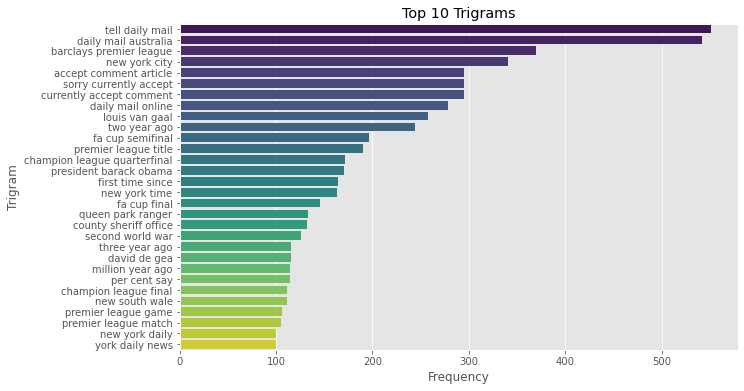

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you already have the 'all_uni_labels' variable defined

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=all_tri_labels.values, y=all_tri_labels.index, palette='viridis')

# Set plot labels and title
plt.xlabel('Frequency')
plt.ylabel('Trigram')
plt.title('Top 10 Trigrams')

# Display the plot
plt.show()